# Using DCRNN for speed prediction of the traffic

The details about the data is shown in the notebook
https://github.com/mhmdrdwn/traffic/blob/main/notebooks/tgcn-seoul-dataset.ipynb

The data: https://github.com/yuyolshin/SeoulSpeedData

In [1]:
import torch
from IPython.display import clear_output

pt_version = torch.__version__

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

## Using Seoul Urban Core Data

In [2]:
import numpy as np
import pandas as pd

def read_data(features_csv, adj_csv):
    urban_core_speeds = pd.read_csv(features_csv, header=None)
    adj_matrix_df = pd.read_csv(adj_csv, header=None)
    adj_matrix = np.array(adj_matrix_df)

    speeds_df = urban_core_speeds.iloc[:, 7:]
    speeds = np.array(speeds_df)
    
    return adj_matrix_df, urban_core_speeds, adj_matrix, speeds

adj_matrix_df, urban_core_speeds, adj_matrix, speeds = read_data(
    '../input/seoul-speed-data/urban-core.csv', 
    '../input/seoul-speed-data/Adj(urban-core).csv')

In [7]:
"""Train test split the data"""

test_split = 6 * 12 * 24 # 6 days X 12 measurements per hour X 24 hours
val_split = 2 * 12 * 24

split = speeds.shape[1] - test_split
train_data = speeds[:, :split-int(val_split)]
test_data = speeds[:, split:]
val_data = speeds[:, split-int(val_split):split]

print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
print("Val data: ", val_data.shape)

Train data:  (304, 6336)
Test data:  (304, 1728)
Val data:  (304, 576)


In [8]:
"""Min max standardizing the data"""
max_speed = train_data.max()
min_speed = train_data.min()

train_data = (train_data - min_speed) / (max_speed - min_speed)
test_data = (test_data - min_speed) / (max_speed - min_speed)
val_data = (val_data - min_speed) / (max_speed - min_speed)

train_data.shape, test_data.shape, val_data.shape

((304, 6336), (304, 1728), (304, 576))

Here we build the features and labels of the time series, The features vectors are of length 10 while the prediction is the next 5 steps in the sequence. We formulate the inputs and outputs as sequences

In [9]:
"""Ref: https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html"""

sequence_len = 10
prediction_len = 5

def build_features_labels(sequence_len, prediction_len, train_data, test_data, val_data):
    X_train, Y_train, X_test, Y_test, X_val, Y_val = [], [], [], [], [], []

    for i in range(train_data.shape[1] - int(sequence_len + prediction_len - 1)):
        a = train_data[:, i : i + sequence_len + prediction_len]
        X_train.append(a[:, :sequence_len])
        Y_train.append(a[:, sequence_len:sequence_len+prediction_len])

    for i in range(test_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = test_data[:, i : i + sequence_len + prediction_len]
        X_test.append(b[:, :sequence_len])
        Y_test.append(b[:, sequence_len:sequence_len+prediction_len])
        
    for i in range(val_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = val_data[:, i : i + sequence_len + prediction_len]
        X_val.append(b[:, :sequence_len])
        Y_val.append(b[:, sequence_len:sequence_len+prediction_len])
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)
    
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

X_train, Y_train, X_test, Y_test, X_val, Y_val = build_features_labels(sequence_len, 
                                                                       prediction_len, 
                                                                       train_data, 
                                                                       test_data, 
                                                                       val_data)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6322, 304, 10)
(6322, 304, 5)
(1714, 304, 10)
(1714, 304, 5)
(562, 304, 10)
(562, 304, 5)


We need to convert the input data into graph temporal object to feed to the model in the torch geometric library, The object we use here is Static Graph Temporal Signal. There are other object that are Dynamic. In Dynamic, we expect that the graph changes over time but here the graph topology does not change over time. We take the adjacency matrix and get the indices where there are connections between nodes and call it edge index. Edge attribute is the value of the connection between nodes. Those two are passed along with the traditional X and y (X is 10 steps in time series whie y is the next 5 steps in the series).

In [10]:
edges = np.nonzero(adj_matrix)
edges = np.vstack([edges, adj_matrix[edges]])
edge_index = edges[:2, :].astype(float)
edge_attr = edges[2, :].astype(float)
print('Edges shape: ', edge_index.shape, ', Attr shape: ',edge_attr.shape)

from torch_geometric_temporal.signal import StaticGraphTemporalSignal
train_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
val_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_val, Y_val)
next(iter(train_loader))

Edges shape:  (2, 1696) , Attr shape:  (1696,)


Data(x=[304, 10], edge_index=[2, 1696], edge_attr=[1696], y=[304, 5])

The DCRNN model (Diffusion Convolutional Recurrent Neural Network) https://arxiv.org/abs/1707.01926. The model uses diffusion convolution to handle complex spatial dependency, RNN (GRU) to handle temporal dynamics and encoder-decoder architecture to handle long term dependecny. Diffusion convolution is used to quantify the reachability between the nodes in the graphs (each node to surrouding nodes which influence it). The the diffusion cnvolution equation from the paper contains convolution kernel, features matrix (input) and adjacency matrix. This is done by convolution of the node own features, then add convolution of nearest connected nodes features, and the convolving the second nearest neighbour features and so on. A brief explanation with mathimatical explanation of the diffusion convolution is here https://www.youtube.com/watch?v=lN8HrGFK3l0

In Gated Recurrent Units (GRU), the diffusion convolution will substitute the matrix multiplications in GRU set of equations to form DCGRU. The encoder-decoder is a standard sequence to sequence model. Both the encoder and the decoder are DCGRU. Historical time series are fed into the encoder and use its final states are fed to the decoder. Finally, the decoder makes predictions based on either previous ground truth or the model output.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  


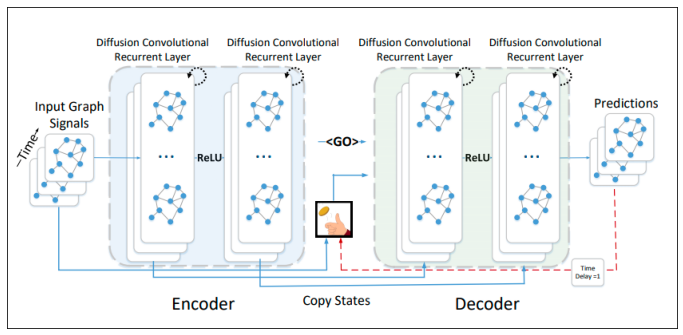

In [11]:
"""Ref: https://arxiv.org/abs/1707.01926"""
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12,12))
plt.imshow(mpimg.imread('https://raw.githubusercontent.com/mhmdrdwn/traffic/main/plots/dcrnn.png'))
plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                left=False,right=False, labelleft=False, labelbottom=False) 
plt.show()

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class DCRNNModel(torch.nn.Module):
    def __init__(self, node_features, output_len):
        super(DCRNNModel, self).__init__()
        self.dcrnn = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, output_len)

    def forward(self, x, edge_index, edge_weight):
        h = self.dcrnn(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [13]:
def evaluate_model(model, val_loader):
    loss = 0
    step = 0
    model.eval()
    with torch.no_grad():
        for snapshot in val_loader:
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss = loss + torch.mean(torch.abs(y_hat-snapshot.y)) 
            step += 1
        loss = loss / (step + 1)
    
    print("Val MAE: {:.4f}".format(loss.item()))
    return loss

The DCRNN is a sequence to sequence architecture, So it's more appropriate to pass the inputs and outputs as sequences, Here each output length is 5 data steps

In [14]:
model = DCRNNModel(node_features = 10, output_len=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_losses, val_losses = [], []

for epoch in range(30):
    print('Epoch: ', epoch+1)
    print('==========')
    loss = 0
    
    model.train()
    for time, snapshot in enumerate(train_loader):
        snapshot = snapshot.to(device)
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean(torch.abs(y_hat-snapshot.y))
    loss = loss / (time+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_losses.append(loss.item())
    
    print("Train MAE: {:.4f}".format(loss.item()))
    
    va_loss = evaluate_model(model, val_loader)
    val_losses.append(va_loss.item())

Epoch:  1
Train MAE: 0.3100
Val MAE: 0.2573
Epoch:  2
Train MAE: 0.2647
Val MAE: 0.2022
Epoch:  3
Train MAE: 0.2082
Val MAE: 0.1356
Epoch:  4
Train MAE: 0.1391
Val MAE: 0.0764
Epoch:  5
Train MAE: 0.0771
Val MAE: 0.0665
Epoch:  6
Train MAE: 0.0656
Val MAE: 0.1042
Epoch:  7
Train MAE: 0.1048
Val MAE: 0.1026
Epoch:  8
Train MAE: 0.1031
Val MAE: 0.0758
Epoch:  9
Train MAE: 0.0753
Val MAE: 0.0460
Epoch:  10
Train MAE: 0.0448
Val MAE: 0.0428
Epoch:  11
Train MAE: 0.0428
Val MAE: 0.0590
Epoch:  12
Train MAE: 0.0605
Val MAE: 0.0687
Epoch:  13
Train MAE: 0.0709
Val MAE: 0.0682
Epoch:  14
Train MAE: 0.0705
Val MAE: 0.0595
Epoch:  15
Train MAE: 0.0614
Val MAE: 0.0481
Epoch:  16
Train MAE: 0.0490
Val MAE: 0.0441
Epoch:  17
Train MAE: 0.0440
Val MAE: 0.0483
Epoch:  18
Train MAE: 0.0478
Val MAE: 0.0529
Epoch:  19
Train MAE: 0.0520
Val MAE: 0.0527
Epoch:  20
Train MAE: 0.0516
Val MAE: 0.0476
Epoch:  21
Train MAE: 0.0462
Val MAE: 0.0424
Epoch:  22
Train MAE: 0.0410
Val MAE: 0.0425
Epoch:  23
Train MA

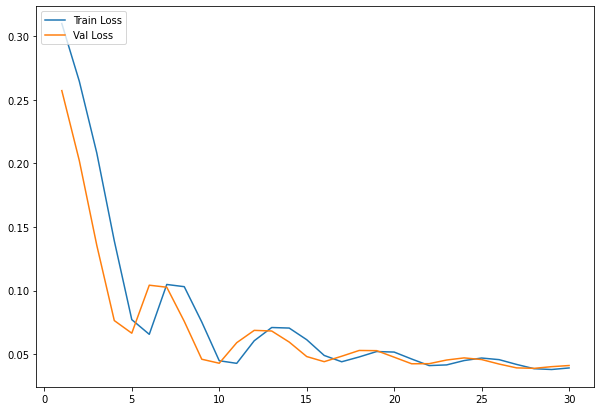

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.legend(loc="upper left")
plt.show()

In [16]:
"""Make predictions for test data"""
model.eval()
y_preds = list()
y_true = list()

for snapshot in test_loader:
    y = snapshot.y.cpu().numpy().reshape(-1)
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).view(len(snapshot.x), -1).cpu().detach().numpy().reshape(-1)

    y = np.array(y * max_speed)
    y_pred = np.array((y_pred) * max_speed)
    y_preds.extend(list(y_pred))
    y_true.extend(list(y))
    
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_preds = y_preds.reshape(int(y_preds.shape[0]/(304*5)), 304, 5)
y_true = y_true.reshape(int(y_true.shape[0]/(304*5)), 304, 5)

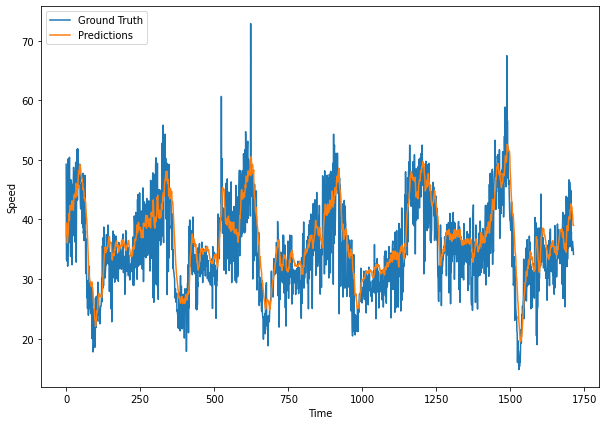

In [17]:
"""show one sensor time series only first time step"""
y_sample = y_true[:, 2, 0]
y_pred_sample = y_preds[:, 2, 0]

plt.figure(figsize=(10,7))
plt.plot(range(len(y_sample)), y_sample, label='Ground Truth')
plt.plot(range(len(y_pred_sample)), y_pred_sample, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend(loc="upper left")
plt.show()

In [19]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  0.000001 #add small values to true velocities to avoid division by zeros
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))
print('MAPE: ', mean_absolute_percentage_error(y_true.flatten(), y_preds.flatten()), "%")

RMSE:  5.2136264
MAE:  3.9257426
MAPE:  18.07137131690979 %


# References:

- Shin, Y., & Yoon, Y. (2020). Incorporating dynamicity of transportation network with multi-weight traffic graph convolutional network for traffic forecasting. IEEE Transactions on Intelligent Transportation Systems.

- Li, Yaguang & Yu, Rose & Shahabi, Cyrus & Liu, Yan. (2018). Diffusion Convolutional Recurrent Neural Network: Data-Driven Traffic Forecasting. 

- https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html

- https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/recurrent/dcrnn.html

- https://pytorch-geometric-temporal.readthedocs.io/en/latest/notes/introduction.html